<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.CrowdCounting/blob/main/0_training_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import tensorflow as tf
from abc import ABC, abstractmethod
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from keras import backend as K 
from keras.utils.layer_utils import count_params 

from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Conv2D,
    Dropout
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## PEP8 standard

In [ ]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

## Custom packages

In [ ]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [ ]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager

## Setup paths

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/7.CrowdCounting/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Models/trial_1 already exists


# Helper functions

In [ ]:
def visualize_predictions(model_, generator_):
        X_batch, Y_batch = next(generator_)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        predictions = model_.predict(X_batch)
        print(type(predictions), predictions.shape)

        _, ax = plt.subplots(3, 3, figsize=(10, 10))
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(f'Ground truth: {Y_batch[i]}\nPredicted: {predictions[i]}')
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax_hist.hist(Y_batch, label='ground truth labels')
        ax_hist.hist(predictions, label='model predictions'),

        _, ax_predictions = plt.subplots()
        ax_predictions.plot(
            Y_batch,
            predictions,
            linestyle='None',
            marker='o',
            # markerfacecolor='white',
            markersize=3
        )

        min_val = min(np.min(Y_batch), np.min(predictions))
        max_val = max(np.max(Y_batch), np.max(predictions))
        ax_predictions.plot(
            np.arange(int(min_val), int(max_val)),
            np.arange(int(min_val), int(max_val)),
            label='perfect match'
        )
        ax_predictions.set_xlabel('ground_truth')
        ax_predictions.set_ylabel('predictions')
        ax_predictions.grid()
        ax_predictions.legend()

In [ ]:
def save_history(history, target_path_):
    # assert os.path.isdir(target_path_)
    df = pd.DataFrame(history.history)
    df.to_csv(target_path_)

In [ ]:
def plot_history(history_, metrics_):
    _, ax = plt.subplots()
    ax.plot(history_.history[metrics_], label='train')
    ax.plot(history_.history[f'val_{metrics_}'], label='validation')
    ax.grid()
    ax.legend(shadow=True)

In [ ]:
def count_parameters(model): 
    trainable_count = count_params(model.trainable_weights) 
    non_trainable_count = count_params(model.non_trainable_weights) 
     
    return { 
        'Total parameters': trainable_count + non_trainable_count, 
        'Trainable parameters': trainable_count, 
        'Non-trainable parameters': non_trainable_count 
    }

In [ ]:
def train_model_with_unfreezed_layers(
    model_class_,
    model_params_dict_,
    optimizer_,
    model_name_,
    n_unfreezed_layers_,
    epochs_,
    to_freeze_=True
):
    model = model_class_(
        name_=f'{model_name_}_{n_unfreezed_layers_}_unfreezed_layers',
        **model_params_dict_,
    )

    model.prepare_model()
    if to_freeze_:
        model.unfreeze_n_layers(n_unfreezed_layers_)
    model.compile_model(optimizer_=optimizer_)

    print(f'Training the model: {model.name}')
    print(f'# unfreezed layers: {n_unfreezed_layers_}')
    print(f'Parameters of model: {count_parameters(model.model)}')

    history = model.fit(
        epochs_=epochs_,
        callbacks_=[
            EarlyStopping(
                monitor='val_mse',
                mode='min',
                patience=5
            ),
            ReduceLROnPlateau(
                monitor='val_mse',
                patience=3,
                factor=0.2,
                min_lr=0.000001
            ),
            ModelCheckpoint(
                filepath=os.path.join(
                    manager.models_trial_path,
                    model.name,
                    model.name
                ),
                save_weights_only=True
            )
        ]
    )
    validation_results = model.model.evaluate(model.validation_generator)
    print(f'Validation results: {validation_results}')
    print('Saving history')
    
    save_history(
        history,
        os.path.join(manager.models_trial_path, f'{model.name}.csv')
    )

In [ ]:
class NNModel(ABC):
    def __init__(
        self,
        name_,
        input_image_size_,
        validation_split_,
        batch_size_,
        trainval_labels_df_,
        test_labels_df_,
        frames_directory_=frames_directory
    ):
        self.random_state = 42
        self.name = name_
        self.input_image_size = input_image_size_
        self.validation_split = validation_split_
        self.batch_size = batch_size_
        self.frames_directory = frames_directory_


        self.data_generator_parameters = None
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None
        self.model = None
        self.init_data_generator_parameters()
        self.init_data_generators(
            trainval_labels_df_,
            test_labels_df_
        )
    
    def __repr__(self):
        return f'''
            {
                self.random_state,
                self.name,
                self.input_image_size,
                self.validation_split,
                self.batch_size
            }
        '''
    @abstractmethod
    def init_data_generator_parameters(self):
        # Augmentation / preprocessing parameters
        pass
    
    def init_data_generators(
        self,
        trainval_labels_df_,
        test_labels_df_
    ):
        trainval_data_generator = ImageDataGenerator(
            **self.data_generator_parameters,
            validation_split=self.validation_split)

        test_data_generator = ImageDataGenerator(
            **self.data_generator_parameters)
        
        common_flow_params = dict(
            directory=self.frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        self.train_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='training',
            dataframe=trainval_labels_df_
        )

        self.validation_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='validation',
            dataframe=trainval_labels_df_
        )

        self.test_generator = test_data_generator.flow_from_dataframe(
            **common_flow_params,
            dataframe=test_labels_df_
        )

    def visualize_data(self):
        X_batch, Y_batch = next(self.train_generator)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        _, ax = plt.subplots(3, 3, figsize=(10, 10))
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(Y_batch[i])
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax_hist.hist(Y_batch)
        
    @abstractmethod
    def prepare_model(self):
        pass

    def compile_model(
        self,
        optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001)
    ):
        self.model.compile(
            optimizer=optimizer_,  # tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse', 'mae']
        )

    def unfreeze_n_layers(self, n_layers_to_freeze_):
        assert n_layers_to_freeze_ > 0

        for layer in self.model.layers[:-n_layers_to_freeze_]:
            layer.trainable = False
        for layer in self.model.layers[-n_layers_to_freeze_:]:
            layer.trainable = True
    
    def fit(self, epochs_, callbacks_):
        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        # print(f'Saving history')
        # save_history(
        #     history,
        #     os.path.join(
        #         manager.models_trial_path, f'{self.name}.csv'
        #     )
        # )
        return self.learning_history

# Data split

In [ ]:
len(os.listdir(os.path.join(manager.data_root_path, 'frames_pretraining')))

1637

In [ ]:
len(os.listdir(os.path.join(manager.data_root_path, 'frames')))

2000

In [ ]:
frames = os.listdir(os.path.join(manager.data_root_path, 'frames'))

In [ ]:
sorted(frames[:9])

['seq_000974.jpg',
 'seq_000975.jpg',
 'seq_000985.jpg',
 'seq_000987.jpg',
 'seq_000988.jpg',
 'seq_000990.jpg',
 'seq_001003.jpg',
 'seq_001005.jpg',
 'seq_001006.jpg']

seq_000975.jpg
seq_000985.jpg
seq_000987.jpg
seq_001006.jpg


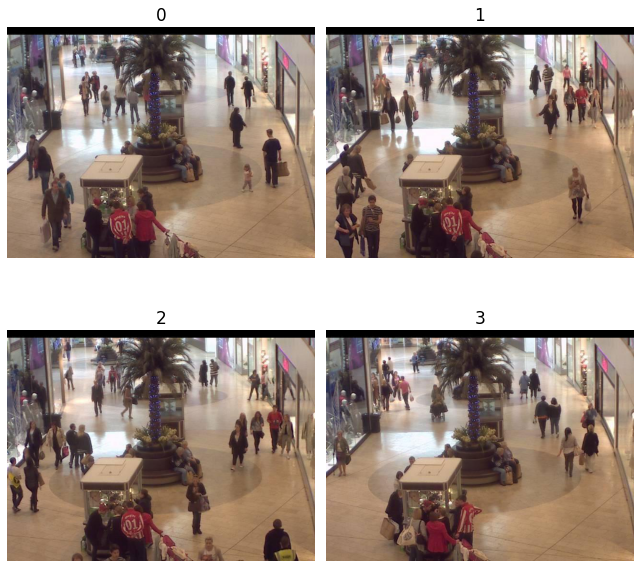

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(9, 9))
ax = ax.flatten()

for idx, frame in enumerate(sorted(frames[:4])):
    img = mpimg.imread(
        os.path.join(
            manager.data_root_path,
            'frames',
            frame  # 'seq_001006.jpg'
        )
    )
    print(frame)
    ax[idx].imshow(img)
    ax[idx].set_title(idx, fontsize=17)
    ax[idx].axis('off')

plt.tight_layout()

In [ ]:
frames_pretrain_directory = os.path.join(
    manager.data_root_path, 'frames_pretraining')
labels_pretrain_df = pd.read_csv(
    os.path.join(manager.data_root_path, 'labels_pretraining.csv'),
    index_col='Unnamed: 0')

print(labels_pretrain_df.head(1))
print(labels_pretrain_df.shape)

   id  count       image_name
0   1      2  c1s1_000151.jpg
(1637, 3)


In [ ]:
PRETRAIN_TEST_SIZE = 0.01
trainval_labels_pretrain_df, test_labels_pretrain_df = train_test_split(
    labels_pretrain_df,
    test_size=PRETRAIN_TEST_SIZE,
    random_state=42
)
trainval_labels_pretrain_df.shape, test_labels_pretrain_df.shape

((1620, 3), (17, 3))

In [ ]:
frames_directory = os.path.join(manager.data_root_path, 'frames')
labels_df = pd.read_csv(os.path.join(manager.data_root_path, 'labels.csv'))
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
print(labels_df.head(1))

   id  count      image_name
0   1     35  seq_000001.jpg


In [ ]:
TRAINVAL_SIZE = 0.8
RANDOM_STATE = 42

trainval_labels_df, test_labels_df = train_test_split(
    labels_df,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
)
trainval_labels_df.shape, test_labels_df.shape

((1600, 3), (400, 3))

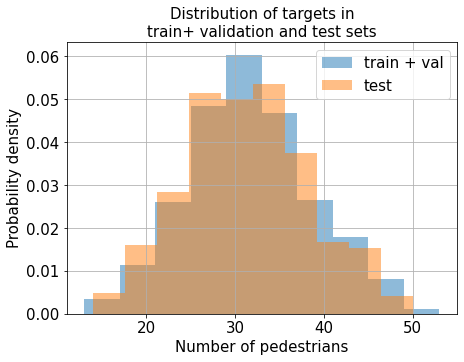

In [ ]:
fontsize = 15

_, ax = plt.subplots(figsize=(7, 5))
ax.hist(trainval_labels_df['count'], density=True, label='train + val', alpha=0.5)
ax.hist(test_labels_df['count'], density=True, label='test', alpha=0.5)
ax.set_xlabel(f'Number of pedestrians', fontsize=fontsize)
ax.set_ylabel(f'Probability density', fontsize=fontsize)
ax.set_title(f'Distribution of targets in\ntrain+ validation and test sets', fontsize=fontsize)
ax.grid()
ax.legend(prop={'size': fontsize})
ax.tick_params(labelsize=15)

# ResNet50

## Create and train the model

In [ ]:
class ResNetModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = resnet50.ResNet50(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
resnet = ResNetModel(
    name_='resnet',
    input_image_size_=(224, 224),
    validation_split_=0.2,  # fraction of images, reserved for validation
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

print(repr(resnet))
resnet.prepare_model()

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.

            (42, 'resnet', (224, 224), 0.2, 64)
        


In [ ]:
resnet.unfreeze_n_layers(7)
resnet.compile_model()

In [ ]:
history = resnet.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                resnet.name,
                resnet.name
            ),
            save_weights_only=True
        )
    ]
)

<ipython-input-58-a32a225ae37b>:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 558s 28s/step - loss: 174.7036 - mse: 174.7036 - mae: 10.1133 - val_loss: 42.1506 - val_mse: 42.1506 - val_mae: 5.3175 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 13s 631ms/step - loss: 45.9748 - mse: 45.9748 - mae: 5.3856 - val_loss: 27.2074 - val_mse: 27.2074 - val_mae: 4.0727 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 13s 627ms/step - loss: 33.0285 - mse: 33.0285 - mae: 4.5277 - val_loss: 18.8522 - val_mse: 18.8522 - val_mae: 3.5109 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 13s 632ms/step - loss: 31.0608 - mse: 31.0608 - mae: 4.4313 - val_loss: 14.7949 - val_mse: 14.7949 - val_mae: 3.0465 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 13s 649ms/step - loss: 28.4613 - mse: 28.4613 - mae: 4.2242 - val_loss: 13.3589 - val_mse: 13.3589 - val_mae: 2.8401 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 13s 630ms/step - loss: 23.1509 - mse

In [ ]:
resnet.model.evaluate(resnet.validation_generator)

5/5 [==============================] - 2s 463ms/step - loss: 9.3846 - mse: 9.3846 - mae: 2.4630


[9.384584426879883, 9.384584426879883, 2.4630417823791504]

In [ ]:
resnet.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Save learning history

In [ ]:
save_history(history, os.path.join(manager.models_trial_path, f'{resnet.name}.csv'))

# Xception

## Prepare and train model

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.xception.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
xception = XceptionModel(
    name_='xception',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
xception.prepare_model()
xception.unfreeze_n_layers(7)
xception.compile_model()

83683744/83683744 [==============================] - 7s 0us/step


In [ ]:
history_xception = xception.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        # ModelCheckpoint(
        #     filepath=os.path.join(
        #         manager.models_trial_path,
        #         xception.name,
        #         xception.name
        #     ),
        #     save_weights_only=True
        # )
    ]
)

<ipython-input-16-01454f8d4adc>:124: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 1119s 56s/step - loss: 263.9821 - mse: 263.9821 - mae: 12.8971 - val_loss: 94.6342 - val_mse: 94.6342 - val_mae: 8.0263 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 18s 866ms/step - loss: 63.1728 - mse: 63.1728 - mae: 6.4273 - val_loss: 40.0176 - val_mse: 40.0176 - val_mae: 4.9111 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 17s 851ms/step - loss: 44.6356 - mse: 44.6356 - mae: 5.3392 - val_loss: 28.3126 - val_mse: 28.3126 - val_mae: 4.1933 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 16s 802ms/step - loss: 35.9220 - mse: 35.9220 - mae: 4.7560 - val_loss: 23.6785 - val_mse: 23.6785 - val_mae: 3.7979 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 16s 776ms/step - loss: 31.6164 - mse: 31.6164 - mae: 4.4520 - val_loss: 20.5261 - val_mse: 20.5261 - val_mae: 3.5127 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 16s 812ms/step - loss: 29.1103 - ms

In [ ]:
xception.model.evaluate(xception.validation_generator)

5/5 [==============================] - 3s 603ms/step - loss: 11.2883 - mse: 11.2883 - mae: 2.6663


[11.288293838500977, 11.288293838500977, 2.6663384437561035]

In [ ]:
xception.model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

## Save data

In [ ]:
save_history(history_xception, os.path.join(manager.models_trial_path, f'{xception.name}.csv'))

# Xception with correct transfer learning (A. Geron)

## Define and train the model

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionModelGeron(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.xception.preprocess_input,
            horizontal_flip=True
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )
    
    def fit(
        self,
        epochs_,
        epochs_initial_,
        callbacks_,
        n_unfreeze_initial_,
        n_unfreeze_final_,
        optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.001),
        optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0005)
    ):
        print(f'Running custom fit')
        print(f'Unfreezing {n_unfreeze_initial_} layers')
        self.unfreeze_n_layers(n_unfreeze_initial_)
        self.compile_model(optimizer_=optimizer_initial_)

        history_initial = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_initial_,
            callbacks=[]
        )

        print(f'Unfreezing {n_unfreeze_final_} layers')
        self.unfreeze_n_layers(n_unfreeze_final_)
        self.compile_model(optimizer_=optimizer_final_)

        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

In [ ]:
xception_geron = XceptionModelGeron(
    name_='xception_geron',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=32,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
xception_geron.prepare_model()

In [ ]:
history_geron = xception_geron.fit(
    epochs_=40,
    epochs_initial_=6,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
        monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_geron.name,
                xception_geron.name
            ),
            save_weights_only=True,
        )
    ],
    n_unfreeze_initial_=5,
    n_unfreeze_final_=15,
    optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.001),
    optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0005)
)

Running custom fit
Unfreezing 5 layers


<ipython-input-21-4badc268b8f7>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_initial = self.model.fit_generator(


Epoch 1/6
40/40 [==============================] - 1047s 26s/step - loss: 149.9412 - mse: 149.9412 - mae: 9.2191 - val_loss: 34.7521 - val_mse: 34.7521 - val_mae: 4.5334
Epoch 2/6
40/40 [==============================] - 15s 365ms/step - loss: 42.3919 - mse: 42.3919 - mae: 5.1581 - val_loss: 26.3779 - val_mse: 26.3779 - val_mae: 3.9796
Epoch 3/6
40/40 [==============================] - 15s 368ms/step - loss: 31.5385 - mse: 31.5385 - mae: 4.4489 - val_loss: 19.8274 - val_mse: 19.8274 - val_mae: 3.4579
Epoch 4/6
40/40 [==============================] - 16s 409ms/step - loss: 25.2792 - mse: 25.2792 - mae: 3.9926 - val_loss: 18.3943 - val_mse: 18.3943 - val_mae: 3.3513
Epoch 5/6
40/40 [==============================] - 15s 360ms/step - loss: 24.5003 - mse: 24.5003 - mae: 3.9332 - val_loss: 24.2039 - val_mse: 24.2039 - val_mae: 3.8115
Epoch 6/6
40/40 [==============================] - 14s 358ms/step - loss: 23.2258 - mse: 23.2258 - mae: 3.8061 - val_loss: 18.6019 - val_mse: 18.6019 - val_ma

<ipython-input-21-4badc268b8f7>:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/40
40/40 [==============================] - 21s 433ms/step - loss: 45.9306 - mse: 45.9306 - mae: 5.0010 - val_loss: 612.6906 - val_mse: 612.6906 - val_mae: 24.3398 - lr: 5.0000e-04
Epoch 2/40
40/40 [==============================] - 16s 402ms/step - loss: 19.0218 - mse: 19.0218 - mae: 3.3992 - val_loss: 119.0497 - val_mse: 119.0497 - val_mae: 10.4088 - lr: 5.0000e-04
Epoch 3/40
40/40 [==============================] - 16s 396ms/step - loss: 18.9238 - mse: 18.9238 - mae: 3.4642 - val_loss: 36.7927 - val_mse: 36.7927 - val_mae: 5.3774 - lr: 5.0000e-04
Epoch 4/40
40/40 [==============================] - 16s 391ms/step - loss: 14.0298 - mse: 14.0298 - mae: 2.9997 - val_loss: 19.5043 - val_mse: 19.5043 - val_mae: 3.7169 - lr: 5.0000e-04
Epoch 5/40
40/40 [==============================] - 17s 417ms/step - loss: 13.4730 - mse: 13.4730 - mae: 2.8644 - val_loss: 59.6393 - val_mse: 59.6393 - val_mae: 7.1760 - lr: 5.0000e-04
Epoch 6/40
40/40 [==============================] - 16s 393ms/st

In [ ]:
xception_geron.model.evaluate(xception_geron.validation_generator)

10/10 [==============================] - 3s 297ms/step - loss: 5.6358 - mse: 5.6358 - mae: 1.8658


[5.635794639587402, 5.635794639587402, 1.8658050298690796]

## Save history

In [ ]:
save_history(
    history_geron,
    os.path.join(manager.models_trial_path, f'{xception_geron.name}.csv')
)

(32, 299, 299, 3) 1.0 -1.0
1/1 [==============================] - 1s 1s/step
<class 'numpy.ndarray'> (32, 1)


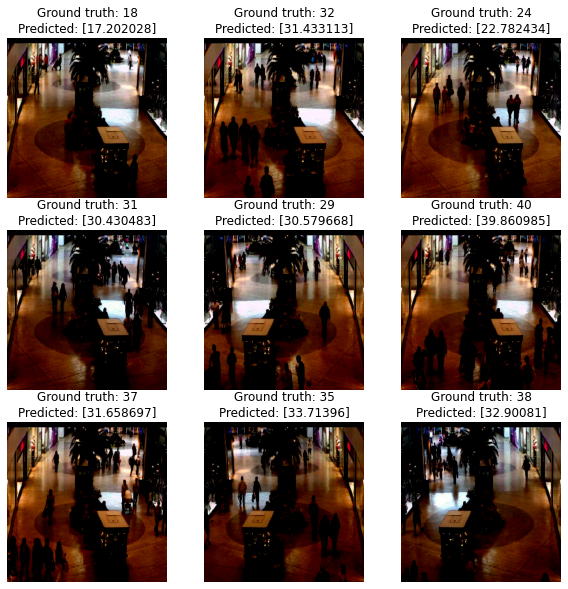

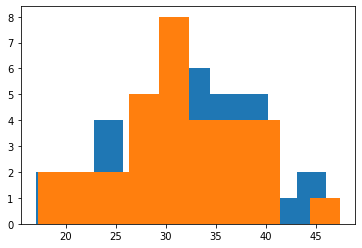

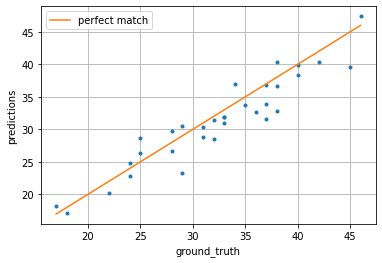

In [ ]:
visualize_predictions(
    xception_geron.model,
    xception_geron.validation_generator
)

# Xception with correct transfer learning (A. Geron),more layers and ELU activation

## Define and train the model

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionModelGeronExperiment(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.xception.preprocess_input,
            horizontal_flip=True
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=500, activation='elu')(x)
        # x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        # x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='relu', kernel_initializer='he_normal')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )
    
    def fit(
        self,
        epochs_,
        epochs_initial_,
        callbacks_,
        n_unfreeze_initial_,
        n_unfreeze_final_,
        optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.001),
        optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0005)
    ):
        print(f'Running custom fit')
        print(f'Unfreezing {n_unfreeze_initial_} layers')
        self.unfreeze_n_layers(n_unfreeze_initial_)
        self.compile_model(optimizer_=optimizer_initial_)

        history_initial = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_initial_,
            callbacks=[]
        )

        print(f'Unfreezing {n_unfreeze_final_} layers')
        self.unfreeze_n_layers(n_unfreeze_final_)
        self.compile_model(optimizer_=optimizer_final_)

        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

In [ ]:
xception_geron_experiment = XceptionModelGeronExperiment(
    name_='xception_geron_experiment_elu',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=32,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
xception_geron_experiment.prepare_model()

In [ ]:
history_geron_experiment = xception_geron_experiment.fit(
    epochs_=10,
    epochs_initial_=0,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
        monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_geron_experiment.name,
                xception_geron_experiment.name
            ),
            save_weights_only=True,
        )
    ],
    n_unfreeze_initial_=7,
    n_unfreeze_final_=17,
    optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.001),
    optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0004)
)

Running custom fit
Unfreezing 7 layers


<ipython-input-47-b21276f4e7df>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_initial = self.model.fit_generator(


Unfreezing 17 layers


<ipython-input-47-b21276f4e7df>:65: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/10
40/40 [==============================] - 21s 450ms/step - loss: 7.3531 - mse: 7.3531 - mae: 2.1116 - val_loss: 5.9749 - val_mse: 5.9749 - val_mae: 1.9303 - lr: 4.0000e-04
Epoch 2/10
40/40 [==============================] - 18s 447ms/step - loss: 4.5063 - mse: 4.5063 - mae: 1.6785 - val_loss: 4.7538 - val_mse: 4.7538 - val_mae: 1.7204 - lr: 4.0000e-04
Epoch 3/10
40/40 [==============================] - 17s 433ms/step - loss: 5.2521 - mse: 5.2521 - mae: 1.8254 - val_loss: 6.8259 - val_mse: 6.8259 - val_mae: 2.1192 - lr: 4.0000e-04
Epoch 4/10
40/40 [==============================] - 16s 392ms/step - loss: 5.5101 - mse: 5.5101 - mae: 1.8416 - val_loss: 7.4694 - val_mse: 7.4694 - val_mae: 2.1782 - lr: 4.0000e-04
Epoch 5/10
40/40 [==============================] - 16s 394ms/step - loss: 6.3341 - mse: 6.3341 - mae: 1.9752 - val_loss: 6.7618 - val_mse: 6.7618 - val_mae: 2.0587 - lr: 4.0000e-04
Epoch 6/10
40/40 [==============================] - 17s 415ms/step - loss: 4.5105 - mse: 4

In [ ]:
xception_geron_experiment.model.evaluate(
    xception_geron_experiment.validation_generator
)

10/10 [==============================] - 3s 277ms/step - loss: 4.3645 - mse: 4.3645 - mae: 1.6211


[4.364451885223389, 4.364451885223389, 1.6211214065551758]

In [ ]:
xception_geron_experiment.model.evaluate(
    xception_geron_experiment.test_generator
)

13/13 [==============================] - 244s 20s/step - loss: 7.6702 - mse: 7.6702 - mae: 2.1688


[7.6701579093933105, 7.6701579093933105, 2.168844699859619]

## Save history

In [ ]:
xception_geron_experiment.name = 'xception_geron_experiment_elu'

In [ ]:
save_history(
    history_geron_experiment,
    os.path.join(
        manager.models_trial_path,
        f'{xception_geron_experiment.name}.csv'
    )
)

(32, 299, 299, 3) 1.0 -1.0
1/1 [==============================] - 1s 695ms/step


<class 'numpy.ndarray'> (32, 1)


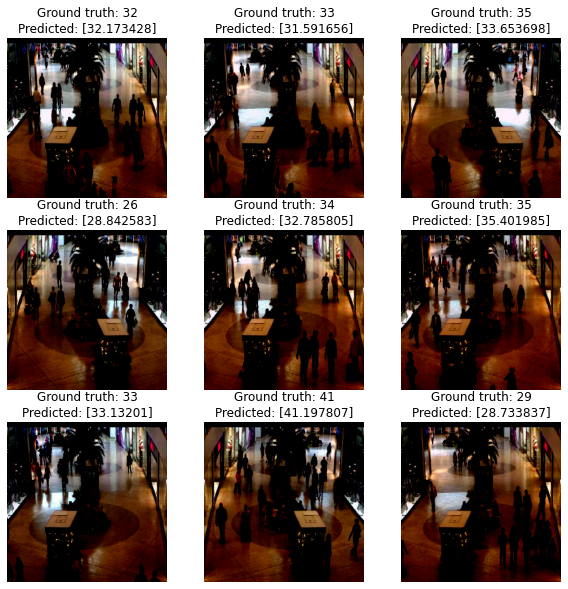

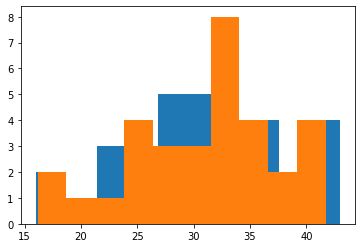

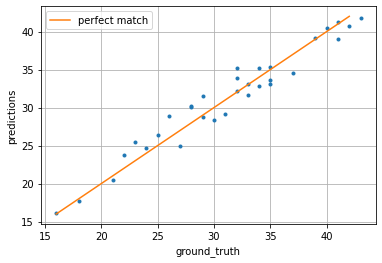

In [ ]:
visualize_predictions(
    xception_geron_experiment.model,
    xception_geron_experiment.validation_generator
)

# Resnet50 with correct transfer learning (A. Geron),more layers and ELU activation

## Define and train the model

In [ ]:
class ResnetModelGeronExperiment(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
            horizontal_flip=True
        )
    
    def prepare_model(self):
        feature_extractor = tf.keras.applications.resnet50.ResNet50(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=500, activation='elu')(x)
        # x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='elu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='relu', kernel_initializer='he_normal')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )
    
    def fit(
        self,
        epochs_,
        epochs_initial_,
        callbacks_,
        n_unfreeze_initial_,
        n_unfreeze_final_,
        optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.001),
        optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0005)
    ):
        print(f'Running custom fit')
        print(f'Unfreezing {n_unfreeze_initial_} layers')
        self.unfreeze_n_layers(n_unfreeze_initial_)
        self.compile_model(optimizer_=optimizer_initial_)

        history_initial = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_initial_,
            callbacks=[]
        )

        print(f'Unfreezing {n_unfreeze_final_} layers')
        self.unfreeze_n_layers(n_unfreeze_final_)
        self.compile_model(optimizer_=optimizer_final_)

        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

In [ ]:
resnet_geron_experiment = ResnetModelGeronExperiment(
    name_='resnet_geron_experiment_elu',
    input_image_size_=(224, 224),
    validation_split_=0.2,
    batch_size_=16,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
resnet_geron_experiment.prepare_model()

In [ ]:
history_resnet_experiment = resnet_geron_experiment.fit(
    epochs_=40,
    epochs_initial_=6,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
        monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                resnet_geron_experiment.name,
                resnet_geron_experiment.name
            ),
            save_weights_only=True,
        )
    ],
    n_unfreeze_initial_=7,
    n_unfreeze_final_=20,
    optimizer_initial_=tf.keras.optimizers.Adam(learning_rate=0.0008),
    optimizer_final_=tf.keras.optimizers.Adam(learning_rate=0.0003)
)

Running custom fit
Unfreezing 7 layers
Epoch 1/6


<ipython-input-26-920aed8c71d9>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_initial = self.model.fit_generator(


80/80 [==============================] - 17s 174ms/step - loss: 68.2090 - mse: 68.2090 - mae: 6.0006 - val_loss: 14.0842 - val_mse: 14.0842 - val_mae: 2.8960
Epoch 2/6
80/80 [==============================] - 12s 148ms/step - loss: 20.1318 - mse: 20.1318 - mae: 3.5073 - val_loss: 10.8276 - val_mse: 10.8276 - val_mae: 2.6416
Epoch 3/6
80/80 [==============================] - 12s 148ms/step - loss: 20.0647 - mse: 20.0647 - mae: 3.6056 - val_loss: 10.1224 - val_mse: 10.1224 - val_mae: 2.5066
Epoch 4/6
80/80 [==============================] - 12s 147ms/step - loss: 16.2074 - mse: 16.2074 - mae: 3.1808 - val_loss: 14.1965 - val_mse: 14.1965 - val_mae: 3.0451
Epoch 5/6
80/80 [==============================] - 12s 147ms/step - loss: 15.3371 - mse: 15.3371 - mae: 3.1135 - val_loss: 9.4557 - val_mse: 9.4557 - val_mae: 2.4576
Epoch 6/6
80/80 [==============================] - 12s 147ms/step - loss: 14.8121 - mse: 14.8121 - mae: 3.0352 - val_loss: 8.8991 - val_mse: 8.8991 - val_mae: 2.3547
Unfree

<ipython-input-26-920aed8c71d9>:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


80/80 [==============================] - 17s 173ms/step - loss: 31.9564 - mse: 31.9564 - mae: 4.1089 - val_loss: 10.3587 - val_mse: 10.3587 - val_mae: 2.5114 - lr: 3.0000e-04
Epoch 2/40
80/80 [==============================] - 13s 164ms/step - loss: 12.3449 - mse: 12.3449 - mae: 2.7958 - val_loss: 15.5690 - val_mse: 15.5690 - val_mae: 3.3051 - lr: 3.0000e-04
Epoch 3/40
80/80 [==============================] - 13s 168ms/step - loss: 10.4992 - mse: 10.4992 - mae: 2.5570 - val_loss: 15.4416 - val_mse: 15.4416 - val_mae: 3.3265 - lr: 3.0000e-04
Epoch 4/40
80/80 [==============================] - 13s 162ms/step - loss: 10.0284 - mse: 10.0284 - mae: 2.5087 - val_loss: 15.9186 - val_mse: 15.9186 - val_mae: 3.3684 - lr: 3.0000e-04
Epoch 5/40
80/80 [==============================] - 13s 162ms/step - loss: 7.6865 - mse: 7.6865 - mae: 2.2145 - val_loss: 5.2944 - val_mse: 5.2944 - val_mae: 1.8237 - lr: 6.0000e-05
Epoch 6/40
80/80 [==============================] - 13s 161ms/step - loss: 6.6704 - m

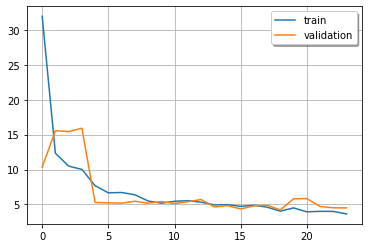

In [ ]:
plot_history(
    history_resnet_experiment,
    'loss'
)

In [ ]:
resnet_geron_experiment.model.evaluate(
    resnet_geron_experiment.validation_generator
)

20/20 [==============================] - 2s 118ms/step - loss: 4.7312 - mse: 4.7312 - mae: 1.6920


[4.7312469482421875, 4.7312469482421875, 1.6919749975204468]

## Save history

In [ ]:
resnet_geron_experiment.name

'resnet_geron_experiment_elu'

In [ ]:
save_history(
    history_resnet_experiment,
    os.path.join(
        manager.models_trial_path,
        f'{resnet_geron_experiment.name}.csv'
    )
)

(16, 224, 224, 3) 151.061 -123.68
1/1 [==============================] - 1s 816ms/step
<class 'numpy.ndarray'> (16, 1)


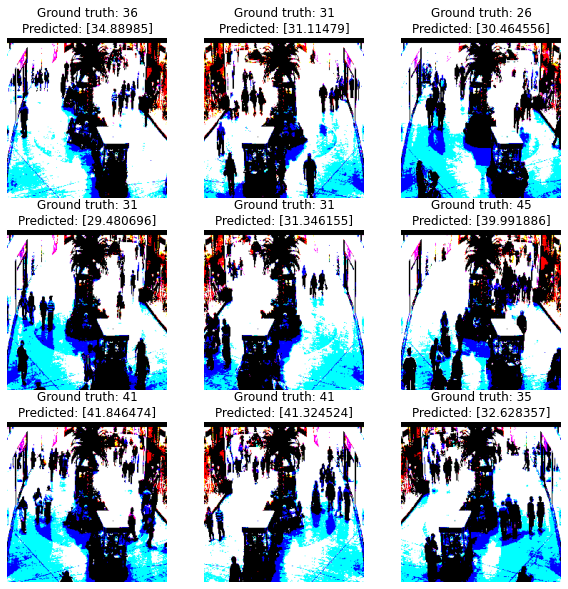

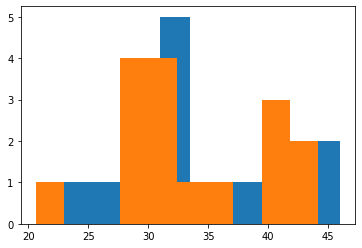

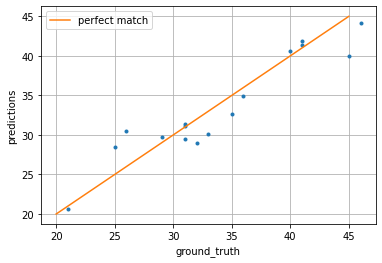

In [ ]:
visualize_predictions(
    resnet_geron_experiment.model,
    resnet_geron_experiment.validation_generator
)

# Inception v3

## Create and train the model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


class InceptionV3Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = InceptionV3(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
inception_v3 = InceptionV3Model(
    name_='inception_v3',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
inception_v3.prepare_model()
inception_v3.unfreeze_n_layers(7)
inception_v3.compile_model()

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
history_inception_v3 = inception_v3.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                inception_v3.name,
                inception_v3.name
            ),
            save_weights_only=True
        )
    ]
)

<ipython-input-58-a32a225ae37b>:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 21s 711ms/step - loss: 190.8772 - mse: 190.8772 - mae: 10.7749 - val_loss: 57.6083 - val_mse: 57.6083 - val_mae: 6.3129 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 13s 671ms/step - loss: 61.3576 - mse: 61.3576 - mae: 6.2407 - val_loss: 39.4749 - val_mse: 39.4749 - val_mae: 4.9376 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 13s 662ms/step - loss: 44.6716 - mse: 44.6716 - mae: 5.3021 - val_loss: 26.5755 - val_mse: 26.5755 - val_mae: 4.0410 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 13s 658ms/step - loss: 37.1766 - mse: 37.1766 - mae: 4.8202 - val_loss: 22.9452 - val_mse: 22.9452 - val_mae: 3.7358 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 16s 784ms/step - loss: 32.0028 - mse: 32.0028 - mae: 4.4934 - val_loss: 20.4407 - val_mse: 20.4407 - val_mae: 3.5802 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 14s 704ms/step - loss: 33.1432 - ms

In [ ]:
inception_v3.model.evaluate(inception_v3.validation_generator)

5/5 [==============================] - 3s 475ms/step - loss: 13.8814 - mse: 13.8814 - mae: 2.9548


[13.881418228149414, 13.881418228149414, 2.9548192024230957]

## Save data

In [ ]:
save_history(history_inception_v3, os.path.join(manager.models_trial_path, f'{inception_v3.name}.csv'))

# Inception resnet V2

## Create and train the model

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


class InceptionResnetV2Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.\
                keras.\
                applications.\
                inception_resnet_v2.\
                preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = InceptionResNetV2(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
inception_resnet_v2 = InceptionResnetV2Model(
    name_='inception_resnet_v2',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
inception_resnet_v2.prepare_model()
inception_resnet_v2.unfreeze_n_layers(7)
inception_resnet_v2.compile_model()

219055592/219055592 [==============================] - 7s 0us/step


In [ ]:
inception_resnet_v2_history = inception_resnet_v2.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                inception_resnet_v2.name,
                inception_resnet_v2.name
            ),
            save_weights_only=True
        )
    ]
)

<ipython-input-58-a32a225ae37b>:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 36s 1s/step - loss: 192.9124 - mse: 192.9124 - mae: 10.7536 - val_loss: 58.8193 - val_mse: 58.8193 - val_mae: 6.2617 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 20s 970ms/step - loss: 63.8768 - mse: 63.8768 - mae: 6.3981 - val_loss: 48.5904 - val_mse: 48.5904 - val_mae: 5.3880 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 20s 991ms/step - loss: 52.2908 - mse: 52.2908 - mae: 5.7415 - val_loss: 34.9725 - val_mse: 34.9725 - val_mae: 4.6273 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 18s 887ms/step - loss: 42.0283 - mse: 42.0283 - mae: 5.1810 - val_loss: 28.4280 - val_mse: 28.4280 - val_mae: 4.2266 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 18s 889ms/step - loss: 36.4909 - mse: 36.4909 - mae: 4.8673 - val_loss: 25.3434 - val_mse: 25.3434 - val_mae: 4.0026 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 19s 939ms/step - loss: 33.6146 - mse: 

In [ ]:
inception_resnet_v2.model.evaluate(inception_resnet_v2.validation_generator)

5/5 [==============================] - 4s 686ms/step - loss: 12.9597 - mse: 12.9597 - mae: 2.8212


[12.9596586227417, 12.9596586227417, 2.8211863040924072]

## Save data

In [ ]:
save_history(inception_resnet_v2_history, os.path.join(manager.models_trial_path, f'{inception_resnet_v2.name}.csv'))

# VGG16

## Prepare and train model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16


class VGG16Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        print(f'VGG16: init data generator parameters')
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.vgg16.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = VGG16(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
vgg16 = VGG16Model(
    name_='vgg16',
    input_image_size_=(224, 224),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

print(repr(vgg16))

VGG16: init data generator parameters
Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.

            (42, 'vgg16', (224, 224), 0.2, 64)
        


In [ ]:
vgg16.prepare_model()
vgg16.unfreeze_n_layers(7)
vgg16.compile_model()

In [ ]:
vgg16.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg16_history = vgg16.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                vgg16.name,
                vgg16.name
            ),
            save_weights_only=True
        )
    ]
)

<ipython-input-11-a32a225ae37b>:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 377s 18s/step - loss: 158.6089 - mse: 158.6089 - mae: 9.6974 - val_loss: 25.4167 - val_mse: 25.4167 - val_mae: 4.0043 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 20s 988ms/step - loss: 43.5072 - mse: 43.5072 - mae: 5.1528 - val_loss: 19.0765 - val_mse: 19.0765 - val_mae: 3.4211 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 14s 672ms/step - loss: 27.8624 - mse: 27.8624 - mae: 4.1849 - val_loss: 21.8067 - val_mse: 21.8067 - val_mae: 3.7144 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 16s 793ms/step - loss: 27.4121 - mse: 27.4121 - mae: 4.1562 - val_loss: 19.4475 - val_mse: 19.4475 - val_mae: 3.5080 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 16s 765ms/step - loss: 22.5205 - mse: 22.5205 - mae: 3.7251 - val_loss: 11.7686 - val_mse: 11.7686 - val_mae: 2.6693 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 15s 722ms/step - loss: 20.1344 - mse:

In [ ]:
vgg16.model.evaluate(vgg16.validation_generator)

5/5 [==============================] - 3s 493ms/step - loss: 22.0039 - mse: 22.0039 - mae: 3.8764


[22.00387954711914, 22.00387954711914, 3.8764147758483887]

## Save learning history

In [ ]:
save_history(
    vgg16_history,
    os.path.join(
        manager.models_trial_path,
        f'{vgg16.name}.csv'
    )
)

# VGG19

## Prepare and train model

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19


class VGG19Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=\
                tf.keras.applications.vgg19.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = VGG19(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
vgg19 = VGG19Model(
    name_='vgg19',
    input_image_size_=(224, 224),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

print(repr(vgg19))

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.

            (42, 'vgg19', (224, 224), 0.2, 64)
        


In [ ]:
vgg19.prepare_model()
vgg19.unfreeze_n_layers(7)
vgg19.compile_model()

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg19_history = vgg19.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            save_weights_only=True,
            filepath=os.path.join(
                manager.models_trial_path,
                vgg19.name,
                vgg19.name
            )
        )
    ]
)

<ipython-input-11-a32a225ae37b>:115: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 16s 725ms/step - loss: 149.8206 - mse: 149.8206 - mae: 9.2949 - val_loss: 28.7494 - val_mse: 28.7494 - val_mae: 4.3939 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 15s 733ms/step - loss: 44.8020 - mse: 44.8020 - mae: 5.2711 - val_loss: 23.6747 - val_mse: 23.6747 - val_mae: 3.7704 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 18s 926ms/step - loss: 32.1978 - mse: 32.1978 - mae: 4.4243 - val_loss: 20.3834 - val_mse: 20.3834 - val_mae: 3.5231 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 18s 916ms/step - loss: 26.2461 - mse: 26.2461 - mae: 4.0257 - val_loss: 12.9713 - val_mse: 12.9713 - val_mae: 2.7928 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 16s 811ms/step - loss: 23.8037 - mse: 23.8037 - mae: 3.8411 - val_loss: 18.4364 - val_mse: 18.4364 - val_mae: 3.3899 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 18s 911ms/step - loss: 20.1680 - mse

In [ ]:
vgg19.model.evaluate(vgg19.validation_generator)

5/5 [==============================] - 3s 514ms/step - loss: 12.7970 - mse: 12.7970 - mae: 2.8505


[12.796979904174805, 12.796979904174805, 2.850526809692383]

## Save learning history

In [ ]:
save_history(
    vgg19_history,
    os.path.join(
        manager.models_trial_path,
        f'{vgg19.name}.csv'
    )
)

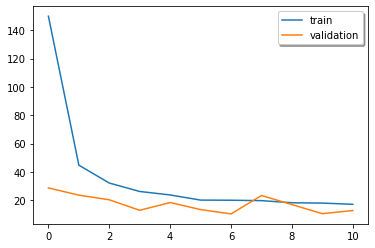

In [ ]:
_, ax = plt.subplots()
ax.plot(vgg19_history.history['loss'], label='train')
ax.plot(vgg19_history.history['val_loss'], label='validation')
ax.legend(shadow=True)

(64, 224, 224, 3) (64,)
2/2 [==============================] - 2s 20ms/step


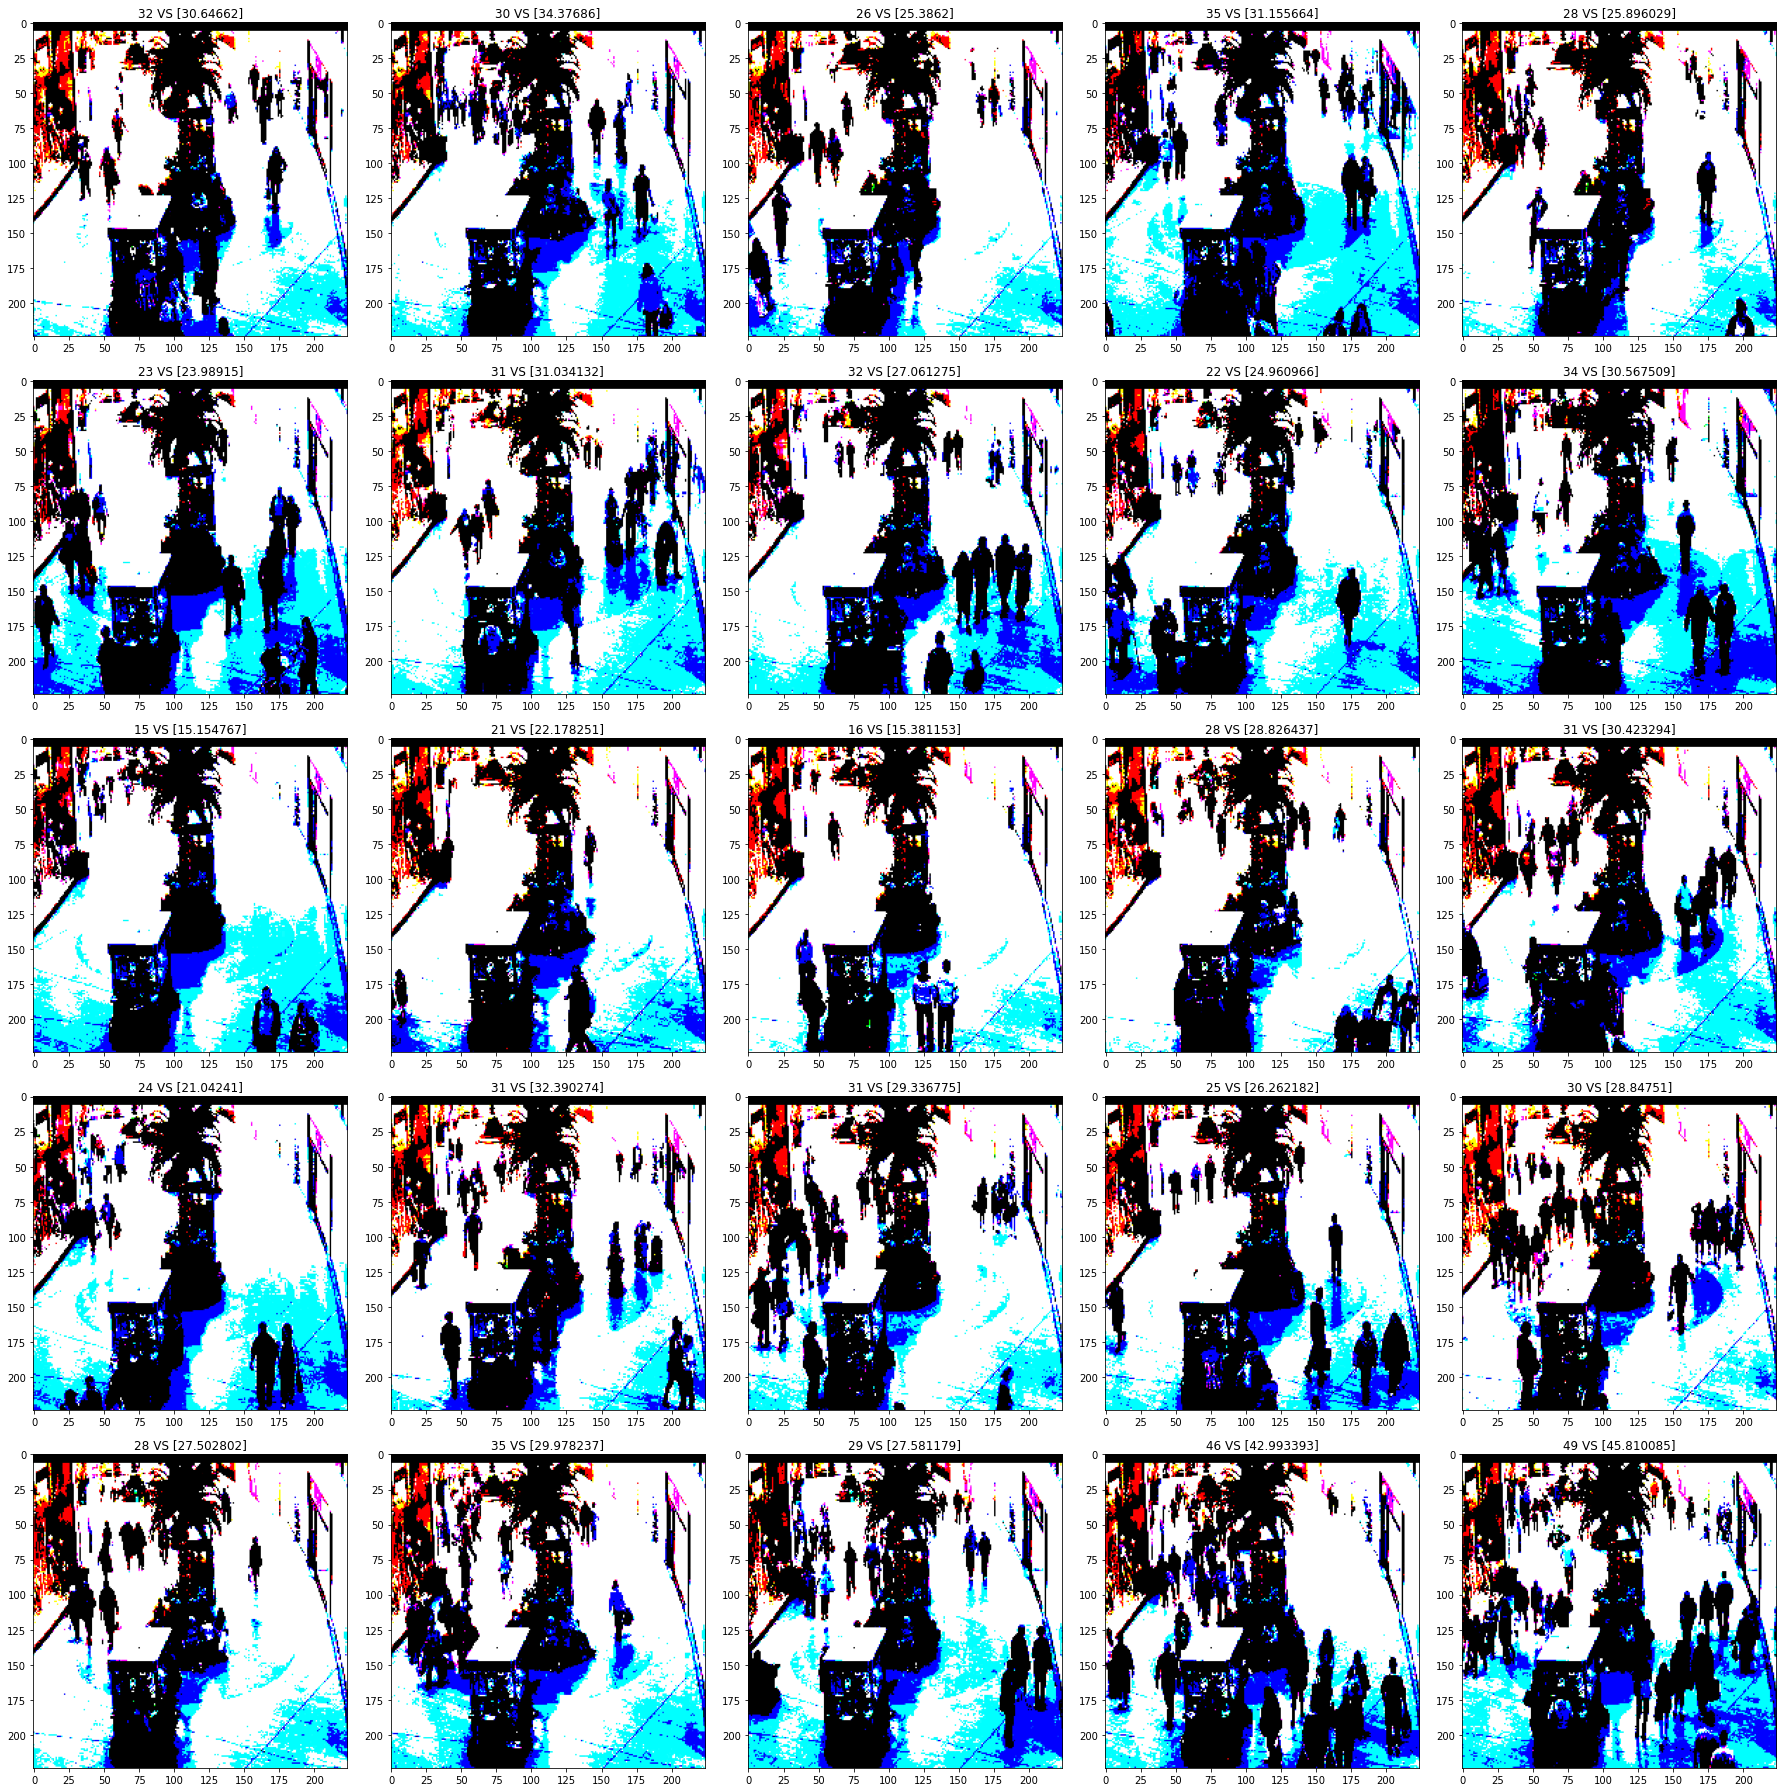

In [ ]:
_, ax = plt.subplots(5, 5, figsize=(25, 25))
ax = ax.flatten()
for i in range(1):
    x, y = resnet.validation_generator[i]
    print(x.shape, y.shape)
    predictions = resnet.model.predict(x)
    for j in range(25):
        ax[j].imshow(x[j])
        ax[j].set_title(f'{y[j]} VS {predictions[j]}')
    plt.tight_layout()

# Xception with data augmentation

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionDataAugmentationModel(XceptionModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        print(f'In Xception with data augmentation')
        self.data_generator_parameters = dict(
            rescale=None,
            horizontal_flip=True,
            # height_shift_range=0.1,
            preprocessing_function=\
                tf.\
                keras.\
                applications.\
                xception.\
                preprocess_input
        )

In [ ]:
xception_with_data_augmentation = XceptionDataAugmentationModel(
    name_='xception_with_data_augmentation',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

In Xception with data augmentation
Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


(64, 299, 299, 3) 1.0 -1.0


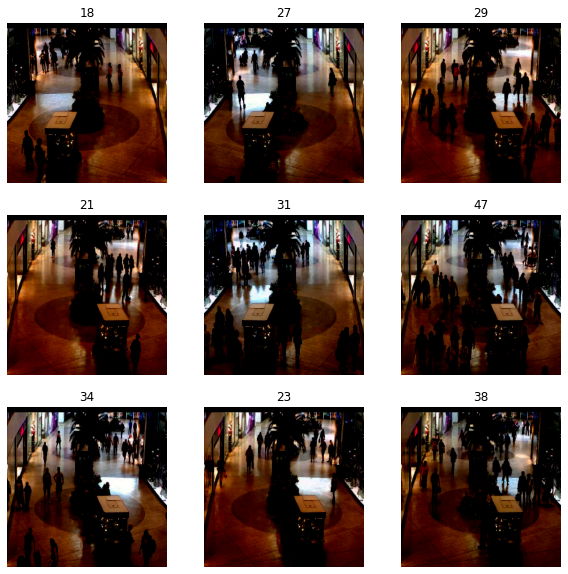

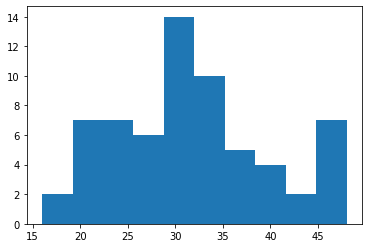

In [ ]:
xception_with_data_augmentation.visualize_data()

In [ ]:
xception_with_data_augmentation.prepare_model()
xception_with_data_augmentation.unfreeze_n_layers(15)
xception_with_data_augmentation.compile_model(
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.0009),
)

In [ ]:
history_xception_data_augmentation = xception_with_data_augmentation.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=6
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_with_data_augmentation.name,
                xception_with_data_augmentation.name
            ),
            save_weights_only=True
        )
    ]
)

<ipython-input-119-8b585c5c4051>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 20s 880ms/step - loss: 223.2127 - mse: 223.2127 - mae: 11.3367 - val_loss: 3391.0554 - val_mse: 3391.0554 - val_mae: 57.8541 - lr: 9.0000e-04
Epoch 2/30
20/20 [==============================] - 17s 823ms/step - loss: 24.2989 - mse: 24.2989 - mae: 3.8604 - val_loss: 676.0726 - val_mse: 676.0726 - val_mae: 25.6397 - lr: 9.0000e-04
Epoch 3/30
20/20 [==============================] - 17s 842ms/step - loss: 18.4242 - mse: 18.4242 - mae: 3.3767 - val_loss: 128.3264 - val_mse: 128.3264 - val_mae: 10.7022 - lr: 9.0000e-04
Epoch 4/30
20/20 [==============================] - 16s 810ms/step - loss: 13.9246 - mse: 13.9246 - mae: 2.9183 - val_loss: 17.2858 - val_mse: 17.2858 - val_mae: 3.4218 - lr: 9.0000e-04
Epoch 5/30
20/20 [==============================] - 16s 813ms/step - loss: 13.1286 - mse: 13.1286 - mae: 2.8410 - val_loss: 10.9533 - val_mse: 10.9533 - val_mae: 2.7056 - lr: 9.0000e-04
Epoch 6/30
20/20 [==============================] - 17s 

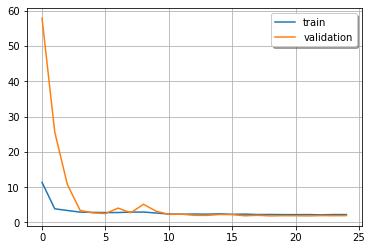

In [ ]:
plot_history(history_xception_data_augmentation, 'mae')

In [ ]:
history_xception_data_augmentation.model.evaluate(
    xception_with_data_augmentation.validation_generator
)

5/5 [==============================] - 4s 698ms/step - loss: 5.7283 - mse: 5.7283 - mae: 1.8921


[5.7283477783203125, 5.7283477783203125, 1.8920732736587524]

In [ ]:
save_history(
    history_xception_data_augmentation,
    os.path.join(
        manager.models_trial_path,
        f'{xception_with_data_augmentation.name}.csv'
    )
)

# Xception with data augmentation and more layers

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionDataAugmentationMoreLayersModel(XceptionModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        print(f'In Xception with data augmentation')
        self.data_generator_parameters = dict(
            rescale=None,
            horizontal_flip=True,
            # height_shift_range=0.1,
            preprocessing_function=\
                tf.\
                keras.\
                applications.\
                xception.\
                preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

In [ ]:
xception_with_data_augmentation_3_layers = XceptionDataAugmentationMoreLayersModel(
    name_='xception_data_augmentation_3_layers',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

In Xception with data augmentation
Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.


In [ ]:
xception_with_data_augmentation_3_layers.prepare_model()
xception_with_data_augmentation_3_layers.unfreeze_n_layers(16)
xception_with_data_augmentation_3_layers.compile_model(
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.0009),
)

In [ ]:
history_xception_with_data_augmentation_3_layers = xception_with_data_augmentation_3_layers.fit(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=6
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_with_data_augmentation_3_layers.name,
                xception_with_data_augmentation_3_layers.name
            ),
            save_weights_only=True
        )
    ]
)

<ipython-input-119-8b585c5c4051>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/30
20/20 [==============================] - 25s 1s/step - loss: 209.0946 - mse: 209.0946 - mae: 10.9727 - val_loss: 2590.2244 - val_mse: 2590.2244 - val_mae: 50.5513 - lr: 9.0000e-04
Epoch 2/30
20/20 [==============================] - 16s 804ms/step - loss: 30.5801 - mse: 30.5801 - mae: 4.2986 - val_loss: 685.4686 - val_mse: 685.4686 - val_mae: 25.7130 - lr: 9.0000e-04
Epoch 3/30
20/20 [==============================] - 16s 795ms/step - loss: 23.4497 - mse: 23.4497 - mae: 3.7990 - val_loss: 159.6632 - val_mse: 159.6632 - val_mae: 12.0299 - lr: 9.0000e-04
Epoch 4/30
20/20 [==============================] - 16s 801ms/step - loss: 20.1353 - mse: 20.1353 - mae: 3.5731 - val_loss: 19.6873 - val_mse: 19.6873 - val_mae: 3.7017 - lr: 9.0000e-04
Epoch 5/30
20/20 [==============================] - 17s 840ms/step - loss: 18.0392 - mse: 18.0392 - mae: 3.3677 - val_loss: 20.9416 - val_mse: 20.9416 - val_mae: 3.8674 - lr: 9.0000e-04
Epoch 6/30
20/20 [==============================] - 17s 818

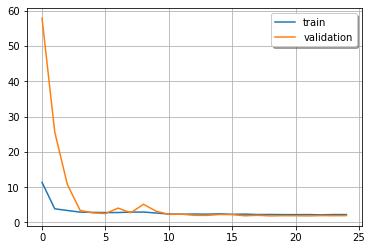

In [ ]:
plot_history(history_xception_data_augmentation, 'mae')

In [ ]:
history_xception_data_augmentation.model.evaluate(
    xception_with_data_augmentation.validation_generator
)

5/5 [==============================] - 3s 556ms/step - loss: 5.7708 - mse: 5.7708 - mae: 1.8861


[5.770848274230957, 5.770848274230957, 1.8860723972320557]

In [ ]:
save_history(
    history_xception_data_augmentation,
    os.path.join(
        manager.models_trial_path,
        f'{xception_with_data_augmentation.name}.csv'
    )
)

# Xception with pretraining

In [ ]:
class DatasetParameters():
    def __init__(
        self,
        validation_split_,
        batch_size_,
        trainval_labels_df_,
        test_labels_df_,
        frames_directory_
    ):
        self.validation_split = validation_split_
        self.batch_size = batch_size_
        self.trainval_labels_df = trainval_labels_df_
        self.test_labels_df = test_labels_df_
        self.frames_directory = frames_directory_



class PretrainingModel(ABC):
    def __init__(
        self,
        name_,
        input_image_size_,
        pretrain_parameters_,
        train_parameters_
    ):
        self.random_state = 42
        self.name = name_
        self.input_image_size = input_image_size_

        self.pretrain_data_generator_parameters = None
        self.train_data_generator_parameters = None
        self.test_data_generator_parameters = None

        self.pretrain_parameters = pretrain_parameters_
        self.train_parameters = train_parameters_

        self.pretrain_train_generator = None
        self.pretrain_validation_generator = None

        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None


        self.model = None
        self.init_data_generator_parameters()
        self.init_data_generators()
    
    @abstractmethod
    def init_data_generator_parameters(self):
        # train_data_generator_parameters
        # pretrain_data_generator_parameters
        # test_data_generator_parameters
        pass
    
    @abstractmethod
    def prepare_model(self):
        pass
    
    def init_data_generators(self):
        pretrain_data_generator = ImageDataGenerator(
            **self.pretrain_data_generator_parameters,
            validation_split=self.pretrain_parameters.validation_split
        )

        trainval_data_generator = ImageDataGenerator(
            **self.train_data_generator_parameters,
            validation_split=self.train_parameters.validation_split)

        test_data_generator = ImageDataGenerator(
            **self.test_data_generator_parameters)
        
        

        print(f'For training, directory: {self.train_parameters.frames_directory}')
        common_train_flow_params = dict(
            directory=self.train_parameters.frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.train_parameters.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        print(f'df for training: {self.train_parameters.trainval_labels_df}')
        self.train_generator = trainval_data_generator.flow_from_dataframe(
            **common_train_flow_params,
            subset='training',
            dataframe=self.train_parameters.trainval_labels_df
        )
        self.validation_generator = trainval_data_generator.flow_from_dataframe(
            **common_train_flow_params,
            subset='validation',
            dataframe=self.train_parameters.trainval_labels_df
        )
        self.test_generator = test_data_generator.flow_from_dataframe(
            **common_train_flow_params,
            dataframe=self.train_parameters.test_labels_df
        )
        
        common_pretrain_flow_params = dict(
            directory=self.pretrain_parameters.frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.pretrain_parameters.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        print(f'df for pre-training: {self.pretrain_parameters.trainval_labels_df}')
        self.pretrain_train_generator = pretrain_data_generator.flow_from_dataframe(
            **common_pretrain_flow_params,
            subset='training',
            dataframe=self.pretrain_parameters.trainval_labels_df
        )

        self.pretrain_validation_generator = pretrain_data_generator.flow_from_dataframe(
            **common_pretrain_flow_params,
            subset='validation',
            dataframe=self.pretrain_parameters.trainval_labels_df
        )

    def _visualize_data(self, generator_):
        X_batch, Y_batch = next(generator_)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        _, ax = plt.subplots(3, 3, figsize=(10, 10))
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(Y_batch[i])
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax_hist.hist(Y_batch)
    
    def visualize_train_data(self, subset_):
        if subset_ == 'train':
            self._visualize_data(self.train_generator)
        elif subset_ == 'validation':
            self._visualize_data(self.validation_generator)
        

    def visualize_pretrain_data(self, subset_):
        if subset_ == 'train':
            self._visualize_data(self.pretrain_train_generator)
        elif subset_ == 'validation':
            self._visualize_data(self.pretrain_validation_generator)

    def unfreeze_n_layers(self, n_layers_to_freeze_):
        assert n_layers_to_freeze_ > 0
        for layer in self.model.layers[:-n_layers_to_freeze_]:
            layer.trainable = False
        for layer in self.model.layers[-n_layers_to_freeze_:]:
            layer.trainable = True
    
    def compile_model(
        self,
        optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001)
    ):
        self.model.compile(
            optimizer=optimizer_,  # tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse', 'mae']
        )

    def pretrain_model(
        self,
        epochs_,
        callbacks_
    ):
        history = self.model.fit_generator(
            self.pretrain_train_generator,
            validation_data=self.pretrain_validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        save_history(
            history,
            os.path.join(
                manager.models_trial_path,
                f'{self.name}_pretraining.csv'
            )
        )
        return history
    
    def train_model(
        self,
        epochs_,
        callbacks_
    ):
        history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        save_history(
            history,
            os.path.join(
                manager.models_trial_path,
                f'{self.name}.csv'
            )
        )
        return history

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionPretrainingModel(PretrainingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        self.train_data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.xception.preprocess_input
        )

        self.pretrain_data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.xception.preprocess_input
        )

        self.test_data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.xception.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )


## Visualize training and pretraining data

(64, 299, 299, 3) 1.0 -1.0


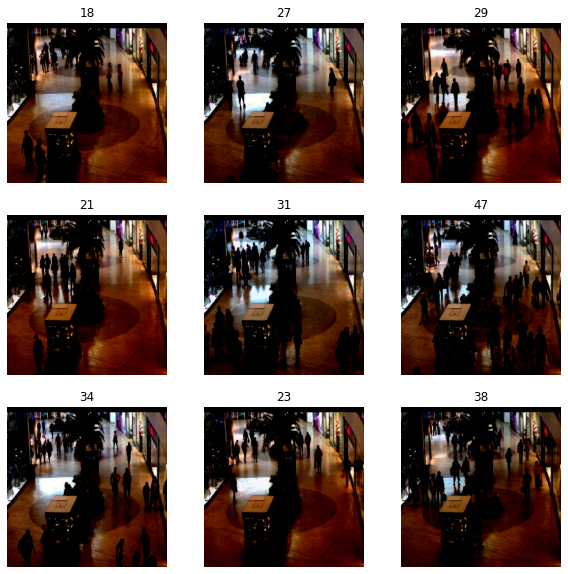

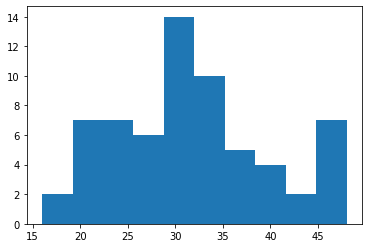

In [ ]:
xception_pretraining.visualize_train_data('train')

(64, 299, 299, 3) 1.0 -1.0


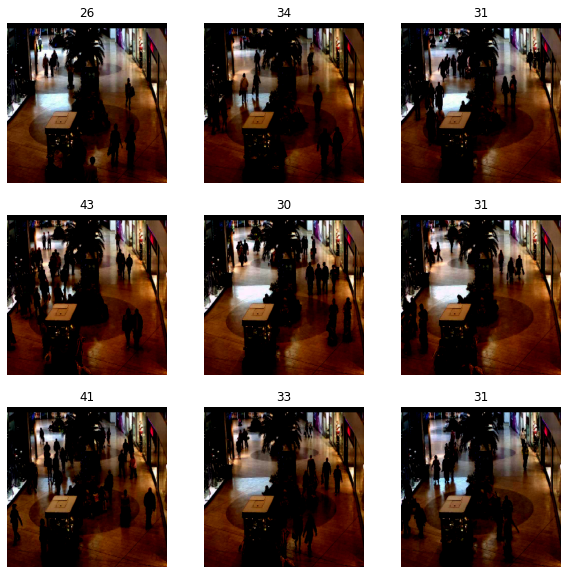

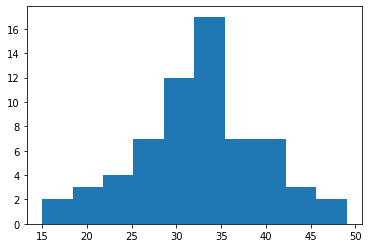

In [ ]:
xception_pretraining.visualize_train_data('validation')

(16, 299, 299, 3) 1.0 -1.0


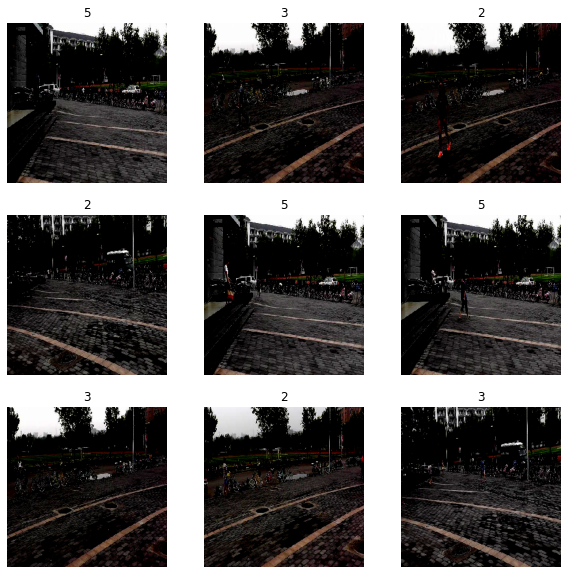

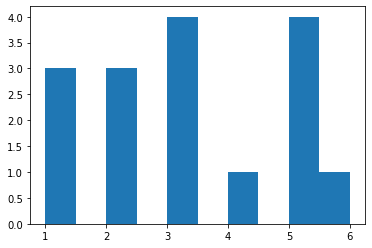

In [ ]:
xception_pretraining.visualize_pretrain_data('train')

(16, 299, 299, 3) 1.0 -1.0


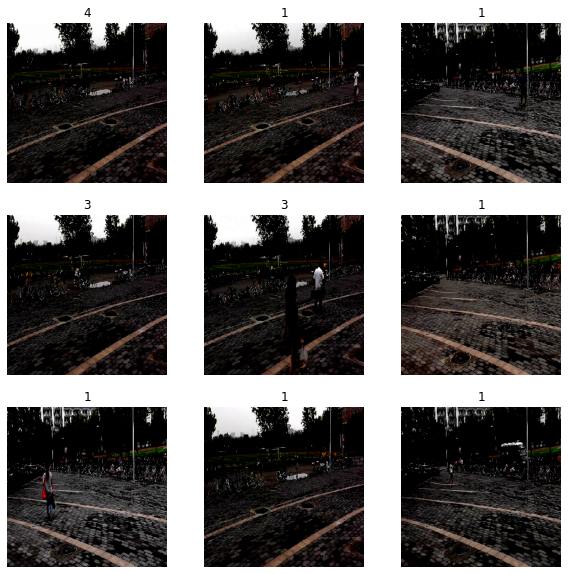

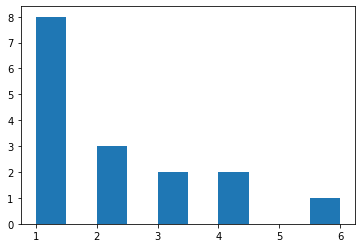

In [ ]:
xception_pretraining.visualize_pretrain_data('validation')

## Prepare and pretrain model

In [ ]:
xception_pretraining = XceptionPretrainingModel(
    name_='xception_with_pretraining',
    input_image_size_=(299, 299),
    pretrain_parameters_=DatasetParameters(
        validation_split_=0.2,
        batch_size_=32,
        trainval_labels_df_=trainval_labels_pretrain_df,
        test_labels_df_=None,
        frames_directory_=frames_pretrain_directory
    ),
    train_parameters_=DatasetParameters(
        validation_split_=0.2,
        batch_size_=32,
        trainval_labels_df_=trainval_labels_df,
        test_labels_df_=test_labels_df,
        frames_directory_=frames_directory
    )
)

For training, directory: /content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data/frames
df for training:         id  count      image_name
968    969     32  seq_000969.jpg
240    241     26  seq_000241.jpg
819    820     33  seq_000820.jpg
692    693     35  seq_000693.jpg
420    421     41  seq_000421.jpg
...    ...    ...             ...
1130  1131     30  seq_001131.jpg
1294  1295     28  seq_001295.jpg
860    861     23  seq_000861.jpg
1459  1460     30  seq_001460.jpg
1126  1127     32  seq_001127.jpg

[1600 rows x 3 columns]
Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
df for pre-training:       id  count       image_name
30    31      5  c3s2_085028.jpg
368  369      4  c4s4_061166.jpg
218  219      4  c4s4_038835.jpg
828  829      4  c5s2_049380.jpg
367  368      6  c4s4_061016.jpg
..   ...    ...              ...
71    72      1  c4s3_073560.jpg
106  107      3  c4s4_001260.jpg
270  271      3  c4s4_04628

In [ ]:
xception_pretraining.prepare_model()
xception_pretraining.unfreeze_n_layers(7)
xception_pretraining.compile_model(
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.0001)
)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
history_pretrain = xception_pretraining.pretrain_model(
    epochs_=20,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=4
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        # ModelCheckpoint(
        #     filepath=os.path.join(
        #         manager.models_trial_path,
        #         xception_pretraining.name,
        #         xception_pretraining.name
        #     ),
        # )
    ]
)

<ipython-input-18-31d684a035d8>:178: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = self.model.fit_generator(


Epoch 1/20
21/21 [==============================] - 21s 482ms/step - loss: 3.7315 - mse: 3.7315 - mae: 1.5013 - val_loss: 2.7008 - val_mse: 2.7008 - val_mae: 1.3537 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - 8s 380ms/step - loss: 2.1231 - mse: 2.1231 - mae: 1.1207 - val_loss: 2.2780 - val_mse: 2.2780 - val_mae: 1.1534 - lr: 1.0000e-04
Epoch 3/20
21/21 [==============================] - 7s 337ms/step - loss: 1.8845 - mse: 1.8845 - mae: 1.0748 - val_loss: 2.0787 - val_mse: 2.0787 - val_mae: 1.0867 - lr: 1.0000e-04
Epoch 4/20
21/21 [==============================] - 8s 381ms/step - loss: 1.7735 - mse: 1.7735 - mae: 1.0398 - val_loss: 1.8263 - val_mse: 1.8263 - val_mae: 1.0417 - lr: 1.0000e-04
Epoch 5/20
21/21 [==============================] - 7s 333ms/step - loss: 1.6211 - mse: 1.6211 - mae: 1.0014 - val_loss: 1.6970 - val_mse: 1.6970 - val_mae: 0.9935 - lr: 1.0000e-04
Epoch 6/20
21/21 [==============================] - 7s 332ms/step - loss: 1.5086 - mse: 1.5086

## Visualize pretrain predictions

(32, 299, 299, 3) 1.0 -1.0
1/1 [==============================] - 1s 767ms/step


<class 'numpy.ndarray'> (32, 1)


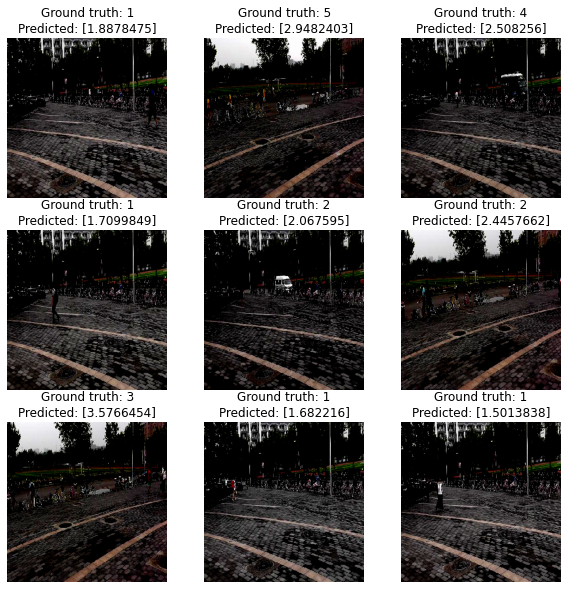

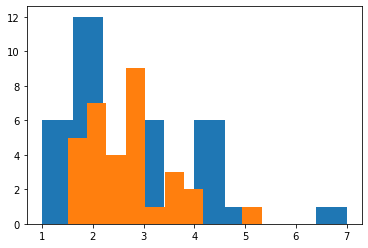

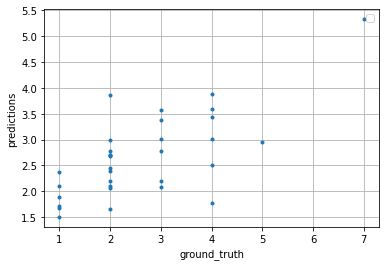

In [ ]:
visualize_predictions(
    xception_pretraining.model,
    xception_pretraining.pretrain_validation_generator
)

## Recompile and train model on actual data

In [ ]:
xception_pretraining.compile_model(
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.0005)
)

In [ ]:
history_train = xception_pretraining.train_model(
    epochs_=30,
    callbacks_=[
        EarlyStopping(
            monitor='val_mse',
            mode='min',
            patience=5
        ),
        ReduceLROnPlateau(
            monitor='val_mse',
            patience=3,
            factor=0.2,
            min_lr=0.000001
        ),
        ModelCheckpoint(
            filepath=os.path.join(
                manager.models_trial_path,
                xception_pretraining.name,
                xception_pretraining.name
            )
        )
    ]
)

<ipython-input-18-31d684a035d8>:198: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = self.model.fit_generator(


Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 133.5569 - mse: 133.5569 - mae: 8.7480

40/40 [==============================] - 452s 11s/step - loss: 133.5569 - mse: 133.5569 - mae: 8.7480 - val_loss: 36.7148 - val_mse: 36.7148 - val_mae: 4.7262 - lr: 5.0000e-04
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 40.4419 - mse: 40.4419 - mae: 5.0809

40/40 [==============================] - 30s 750ms/step - loss: 40.4419 - mse: 40.4419 - mae: 5.0809 - val_loss: 26.2827 - val_mse: 26.2827 - val_mae: 3.9992 - lr: 5.0000e-04
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 32.0819 - mse: 32.0819 - mae: 4.5362

40/40 [==============================] - 29s 720ms/step - loss: 32.0819 - mse: 32.0819 - mae: 4.5362 - val_loss: 21.3877 - val_mse: 21.3877 - val_mae: 3.5583 - lr: 5.0000e-04
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 27.8043 - mse: 27.8043 - mae: 4.1944

40/40 [==============================] - 29s 729ms/step - loss: 27.8043 - mse: 27.8043 - mae: 4.1944 - val_loss: 17.9425 - val_mse: 17.9425 - val_mae: 3.3083 - lr: 5.0000e-04
Epoch 5/30
40/40 [==============================] - ETA: 0s - loss: 24.5256 - mse: 24.5256 - mae: 3.8937

40/40 [==============================] - 29s 726ms/step - loss: 24.5256 - mse: 24.5256 - mae: 3.8937 - val_loss: 19.0552 - val_mse: 19.0552 - val_mae: 3.3405 - lr: 5.0000e-04
Epoch 6/30
40/40 [==============================] - ETA: 0s - loss: 23.1262 - mse: 23.1262 - mae: 3.8226

40/40 [==============================] - 29s 720ms/step - loss: 23.1262 - mse: 23.1262 - mae: 3.8226 - val_loss: 16.5795 - val_mse: 16.5795 - val_mae: 3.2940 - lr: 5.0000e-04
Epoch 7/30
40/40 [==============================] - ETA: 0s - loss: 20.4465 - mse: 20.4465 - mae: 3.5994

40/40 [==============================] - 29s 722ms/step - loss: 20.4465 - mse: 20.4465 - mae: 3.5994 - val_loss: 16.0452 - val_mse: 16.0452 - val_mae: 3.2763 - lr: 5.0000e-04
Epoch 8/30
40/40 [==============================] - ETA: 0s - loss: 20.5342 - mse: 20.5342 - mae: 3.5973

40/40 [==============================] - 29s 724ms/step - loss: 20.5342 - mse: 20.5342 - mae: 3.5973 - val_loss: 13.9846 - val_mse: 13.9846 - val_mae: 2.9736 - lr: 5.0000e-04
Epoch 9/30
40/40 [==============================] - ETA: 0s - loss: 18.3153 - mse: 18.3153 - mae: 3.3962

40/40 [==============================] - 29s 737ms/step - loss: 18.3153 - mse: 18.3153 - mae: 3.3962 - val_loss: 13.9617 - val_mse: 13.9617 - val_mae: 2.9167 - lr: 5.0000e-04
Epoch 10/30
40/40 [==============================] - ETA: 0s - loss: 18.1276 - mse: 18.1276 - mae: 3.3748

40/40 [==============================] - 28s 712ms/step - loss: 18.1276 - mse: 18.1276 - mae: 3.3748 - val_loss: 13.0860 - val_mse: 13.0860 - val_mae: 2.9341 - lr: 5.0000e-04
Epoch 11/30
40/40 [==============================] - ETA: 0s - loss: 16.9080 - mse: 16.9080 - mae: 3.2255

40/40 [==============================] - 29s 722ms/step - loss: 16.9080 - mse: 16.9080 - mae: 3.2255 - val_loss: 12.4041 - val_mse: 12.4041 - val_mae: 2.8114 - lr: 5.0000e-04
Epoch 12/30
40/40 [==============================] - ETA: 0s - loss: 17.1061 - mse: 17.1061 - mae: 3.2737

40/40 [==============================] - 28s 716ms/step - loss: 17.1061 - mse: 17.1061 - mae: 3.2737 - val_loss: 18.0351 - val_mse: 18.0351 - val_mae: 3.3699 - lr: 5.0000e-04
Epoch 13/30
40/40 [==============================] - ETA: 0s - loss: 18.0571 - mse: 18.0571 - mae: 3.3431

40/40 [==============================] - 28s 714ms/step - loss: 18.0571 - mse: 18.0571 - mae: 3.3431 - val_loss: 18.2698 - val_mse: 18.2698 - val_mae: 3.3875 - lr: 5.0000e-04
Epoch 14/30
40/40 [==============================] - ETA: 0s - loss: 16.2065 - mse: 16.2065 - mae: 3.1866

40/40 [==============================] - 29s 722ms/step - loss: 16.2065 - mse: 16.2065 - mae: 3.1866 - val_loss: 11.9383 - val_mse: 11.9383 - val_mae: 2.7542 - lr: 5.0000e-04
Epoch 15/30
40/40 [==============================] - ETA: 0s - loss: 15.4282 - mse: 15.4282 - mae: 3.1091

40/40 [==============================] - 29s 719ms/step - loss: 15.4282 - mse: 15.4282 - mae: 3.1091 - val_loss: 11.8878 - val_mse: 11.8878 - val_mae: 2.7678 - lr: 5.0000e-04
Epoch 16/30
40/40 [==============================] - ETA: 0s - loss: 15.0520 - mse: 15.0520 - mae: 3.0583

40/40 [==============================] - 30s 749ms/step - loss: 15.0520 - mse: 15.0520 - mae: 3.0583 - val_loss: 11.3649 - val_mse: 11.3649 - val_mae: 2.6919 - lr: 5.0000e-04
Epoch 17/30
40/40 [==============================] - ETA: 0s - loss: 14.6182 - mse: 14.6182 - mae: 3.0341

40/40 [==============================] - 29s 719ms/step - loss: 14.6182 - mse: 14.6182 - mae: 3.0341 - val_loss: 11.1644 - val_mse: 11.1644 - val_mae: 2.6819 - lr: 5.0000e-04
Epoch 18/30
40/40 [==============================] - ETA: 0s - loss: 13.5067 - mse: 13.5067 - mae: 2.8851

40/40 [==============================] - 28s 714ms/step - loss: 13.5067 - mse: 13.5067 - mae: 2.8851 - val_loss: 11.7672 - val_mse: 11.7672 - val_mae: 2.7322 - lr: 5.0000e-04
Epoch 19/30
40/40 [==============================] - ETA: 0s - loss: 14.6325 - mse: 14.6325 - mae: 3.0169

40/40 [==============================] - 28s 716ms/step - loss: 14.6325 - mse: 14.6325 - mae: 3.0169 - val_loss: 12.0012 - val_mse: 12.0012 - val_mae: 2.7488 - lr: 5.0000e-04
Epoch 20/30
40/40 [==============================] - ETA: 0s - loss: 13.3519 - mse: 13.3519 - mae: 2.9022

40/40 [==============================] - 28s 716ms/step - loss: 13.3519 - mse: 13.3519 - mae: 2.9022 - val_loss: 10.7681 - val_mse: 10.7681 - val_mae: 2.6269 - lr: 5.0000e-04
Epoch 21/30
40/40 [==============================] - ETA: 0s - loss: 13.4202 - mse: 13.4202 - mae: 2.8526

40/40 [==============================] - 28s 717ms/step - loss: 13.4202 - mse: 13.4202 - mae: 2.8526 - val_loss: 11.1374 - val_mse: 11.1374 - val_mae: 2.6870 - lr: 5.0000e-04
Epoch 22/30
40/40 [==============================] - ETA: 0s - loss: 14.3789 - mse: 14.3789 - mae: 2.9863

40/40 [==============================] - 29s 720ms/step - loss: 14.3789 - mse: 14.3789 - mae: 2.9863 - val_loss: 10.9788 - val_mse: 10.9788 - val_mae: 2.6187 - lr: 5.0000e-04
Epoch 23/30
40/40 [==============================] - ETA: 0s - loss: 15.5810 - mse: 15.5810 - mae: 3.0958

40/40 [==============================] - 28s 710ms/step - loss: 15.5810 - mse: 15.5810 - mae: 3.0958 - val_loss: 10.9115 - val_mse: 10.9115 - val_mae: 2.6530 - lr: 5.0000e-04
Epoch 24/30
40/40 [==============================] - ETA: 0s - loss: 12.6602 - mse: 12.6602 - mae: 2.7982

40/40 [==============================] - 36s 909ms/step - loss: 12.6602 - mse: 12.6602 - mae: 2.7982 - val_loss: 11.7232 - val_mse: 11.7232 - val_mae: 2.6990 - lr: 1.0000e-04
Epoch 25/30
40/40 [==============================] - ETA: 0s - loss: 12.4465 - mse: 12.4465 - mae: 2.7774

40/40 [==============================] - 32s 783ms/step - loss: 12.4465 - mse: 12.4465 - mae: 2.7774 - val_loss: 11.1310 - val_mse: 11.1310 - val_mae: 2.6927 - lr: 1.0000e-04


In [ ]:
xception_pretraining.model.evaluate(
    xception_pretraining.validation_generator
)

10/10 [==============================] - 3s 278ms/step - loss: 11.1310 - mse: 11.1310 - mae: 2.6927


[11.130987167358398, 11.130987167358398, 2.6927151679992676]

In [ ]:
save_history(
    history_train,
    os.path.join(
        manager.models_trial_path,
        f'{xception_pretraining.name}.csv'
    )
)

## Visualize actual data predictions

(32, 299, 299, 3) 1.0 -1.0
1/1 [==============================] - 0s 44ms/step


<class 'numpy.ndarray'> (32, 1)


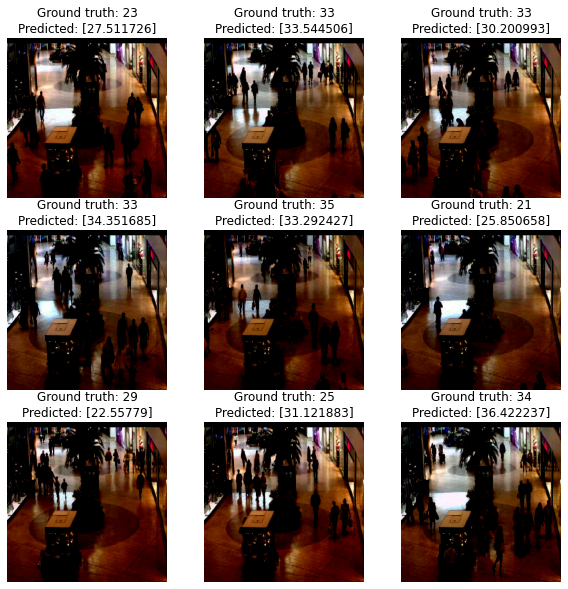

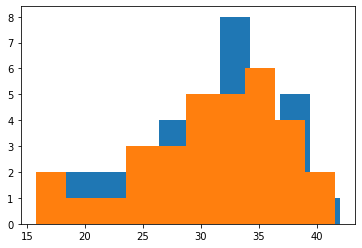

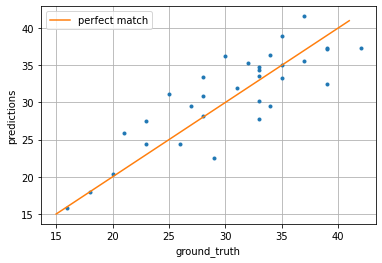

In [ ]:
visualize_predictions(
    xception_pretraining.model,
    xception_pretraining.validation_generator
)

# Generalization ability VS number of unfreezed layers

In [ ]:
# Total number of layers
x = XceptionModel(
    name_='xception',
    input_image_size_=(299, 299),
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)
x.prepare_model()
print(len(x.model.layers))

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
138


In [ ]:
common_function_parameters = dict(
    model_class_=XceptionModel,
    model_name_='xception',
    model_params_dict_=dict(
        input_image_size_=(299, 299),
        validation_split_=0.2,
        batch_size_=64,
        trainval_labels_df_=trainval_labels_df,
        test_labels_df_=test_labels_df
    ),
    epochs_=25
)

## 10 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001),
    n_unfreezed_layers_=10,
    # to_freeze_=False
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_10_unfreezed_layers
# unfreezed layers: 10
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 4144049, 'Non-trainable parameters': 17697832}


<ipython-input-53-7fb46c20ba65>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/25
20/20 [==============================] - 19s 837ms/step - loss: 226.2900 - mse: 226.2900 - mae: 11.4723 - val_loss: 1304.9924 - val_mse: 1304.9924 - val_mae: 35.3717 - lr: 0.0010
Epoch 2/25
20/20 [==============================] - 17s 816ms/step - loss: 27.7794 - mse: 27.7794 - mae: 4.1526 - val_loss: 608.7799 - val_mse: 608.7799 - val_mae: 24.1780 - lr: 0.0010
Epoch 3/25
20/20 [==============================] - 16s 800ms/step - loss: 20.0813 - mse: 20.0813 - mae: 3.4860 - val_loss: 166.8709 - val_mse: 166.8709 - val_mae: 12.2282 - lr: 0.0010
Epoch 4/25
20/20 [==============================] - 17s 825ms/step - loss: 16.0093 - mse: 16.0093 - mae: 3.1582 - val_loss: 69.8074 - val_mse: 69.8074 - val_mae: 7.6019 - lr: 0.0010
Epoch 5/25
20/20 [==============================] - 16s 787ms/step - loss: 15.6008 - mse: 15.6008 - mae: 3.0769 - val_loss: 40.4314 - val_mse: 40.4314 - val_mae: 5.5751 - lr: 0.0010
Epoch 6/25
20/20 [==============================] - 16s 790ms/step - loss: 1

## 15 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001),
    n_unfreezed_layers_=15,
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_15_unfreezed_layers
# unfreezed layers: 15
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 5731249, 'Non-trainable parameters': 16110632}


<ipython-input-53-7fb46c20ba65>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/25
20/20 [==============================] - 20s 872ms/step - loss: 238.5382 - mse: 238.5382 - mae: 11.8045 - val_loss: 7286.1650 - val_mse: 7286.1650 - val_mae: 84.9229 - lr: 0.0010
Epoch 2/25
20/20 [==============================] - 16s 814ms/step - loss: 23.3863 - mse: 23.3863 - mae: 3.7936 - val_loss: 789.1234 - val_mse: 789.1234 - val_mae: 27.7775 - lr: 0.0010
Epoch 3/25
20/20 [==============================] - 17s 816ms/step - loss: 18.2154 - mse: 18.2154 - mae: 3.3890 - val_loss: 211.5521 - val_mse: 211.5521 - val_mae: 14.1111 - lr: 0.0010
Epoch 4/25
20/20 [==============================] - 16s 799ms/step - loss: 17.2580 - mse: 17.2580 - mae: 3.2556 - val_loss: 10.1711 - val_mse: 10.1711 - val_mae: 2.5884 - lr: 0.0010
Epoch 5/25
20/20 [==============================] - 16s 798ms/step - loss: 14.9307 - mse: 14.9307 - mae: 3.0094 - val_loss: 10.5972 - val_mse: 10.5972 - val_mae: 2.6543 - lr: 0.0010
Epoch 6/25
20/20 [==============================] - 16s 814ms/step - loss: 1

## 20 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.001),
    n_unfreezed_layers_=20
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_20_unfreezed_layers
# unfreezed layers: 20
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 7232249, 'Non-trainable parameters': 14609632}


<ipython-input-53-7fb46c20ba65>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/25
20/20 [==============================] - 21s 885ms/step - loss: 246.8873 - mse: 246.8873 - mae: 11.2880 - val_loss: 619.5699 - val_mse: 619.5699 - val_mae: 23.4999 - lr: 0.0010
Epoch 2/25
20/20 [==============================] - 18s 883ms/step - loss: 22.3384 - mse: 22.3384 - mae: 3.7542 - val_loss: 26.3801 - val_mse: 26.3801 - val_mae: 3.9587 - lr: 0.0010
Epoch 3/25
20/20 [==============================] - 17s 855ms/step - loss: 16.4780 - mse: 16.4780 - mae: 3.2105 - val_loss: 77.6853 - val_mse: 77.6853 - val_mae: 7.9837 - lr: 0.0010
Epoch 4/25
20/20 [==============================] - 17s 832ms/step - loss: 13.2853 - mse: 13.2853 - mae: 2.8644 - val_loss: 103.7782 - val_mse: 103.7782 - val_mae: 9.5969 - lr: 0.0010
Epoch 5/25
20/20 [==============================] - 17s 839ms/step - loss: 16.8061 - mse: 16.8061 - mae: 3.2463 - val_loss: 67.3890 - val_mse: 67.3890 - val_mae: 7.7302 - lr: 0.0010
Epoch 6/25
20/20 [==============================] - 17s 844ms/step - loss: 11.1210

## 40 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.0001),
    n_unfreezed_layers_=40
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_40_unfreezed_layers
# unfreezed layers: 40
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 10460201, 'Non-trainable parameters': 11381680}


<ipython-input-53-7fb46c20ba65>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/25
20/20 [==============================] - 25s 1s/step - loss: 753.6157 - mse: 753.6157 - mae: 26.4445 - val_loss: 157.8970 - val_mse: 157.8970 - val_mae: 11.5003 - lr: 1.0000e-04
Epoch 2/25
20/20 [==============================] - 21s 1s/step - loss: 140.9341 - mse: 140.9341 - mae: 9.6598 - val_loss: 369.5229 - val_mse: 369.5229 - val_mae: 18.8097 - lr: 1.0000e-04
Epoch 3/25
20/20 [==============================] - 22s 1s/step - loss: 21.9381 - mse: 21.9381 - mae: 3.7411 - val_loss: 106.6317 - val_mse: 106.6317 - val_mae: 9.7515 - lr: 1.0000e-04
Epoch 4/25
20/20 [==============================] - 20s 1s/step - loss: 14.1635 - mse: 14.1635 - mae: 2.9372 - val_loss: 37.3696 - val_mse: 37.3696 - val_mae: 5.3040 - lr: 1.0000e-04
Epoch 5/25
20/20 [==============================] - 20s 985ms/step - loss: 13.2622 - mse: 13.2622 - mae: 2.8259 - val_loss: 12.7065 - val_mse: 12.7065 - val_mae: 2.8571 - lr: 1.0000e-04
Epoch 6/25
20/20 [==============================] - 21s 1s/step - los

## 60 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.0001),
    n_unfreezed_layers_=60
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_60_unfreezed_layers
# unfreezed layers: 60
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 13688153, 'Non-trainable parameters': 8153728}


<ipython-input-53-7fb46c20ba65>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/25
20/20 [==============================] - 28s 1s/step - loss: 789.7496 - mse: 789.7496 - mae: 27.1191 - val_loss: 283.6502 - val_mse: 283.6502 - val_mae: 15.9546 - lr: 1.0000e-04
Epoch 2/25
20/20 [==============================] - 24s 1s/step - loss: 172.7564 - mse: 172.7564 - mae: 11.0316 - val_loss: 203.4139 - val_mse: 203.4139 - val_mae: 13.5782 - lr: 1.0000e-04
Epoch 3/25
20/20 [==============================] - 23s 1s/step - loss: 19.2396 - mse: 19.2396 - mae: 3.4514 - val_loss: 153.1996 - val_mse: 153.1996 - val_mae: 11.7965 - lr: 1.0000e-04
Epoch 4/25
20/20 [==============================] - 23s 1s/step - loss: 15.5602 - mse: 15.5602 - mae: 3.1186 - val_loss: 27.3482 - val_mse: 27.3482 - val_mae: 4.4721 - lr: 1.0000e-04
Epoch 5/25
20/20 [==============================] - 23s 1s/step - loss: 13.1168 - mse: 13.1168 - mae: 2.8410 - val_loss: 8.7747 - val_mse: 8.7747 - val_mae: 2.3428 - lr: 1.0000e-04
Epoch 6/25
20/20 [==============================] - 23s 1s/step - loss: 

## 85 layers

In [ ]:
train_model_with_unfreezed_layers(
    **common_function_parameters,
    optimizer_=tf.keras.optimizers.Adam(learning_rate=0.0001),
    n_unfreezed_layers_=85
)

Found 1280 validated image filenames.
Found 320 validated image filenames.
Found 400 validated image filenames.
Training the model: xception_85_unfreezed_layers
# unfreezed layers: 85
Parameters of model: {'Total parameters': 21841881, 'Trainable parameters': 17990633, 'Non-trainable parameters': 3851248}


<ipython-input-53-7fb46c20ba65>:118: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.learning_history = self.model.fit_generator(


Epoch 1/25
20/20 [==============================] - 33s 1s/step - loss: 815.7089 - mse: 815.7089 - mae: 27.6398 - val_loss: 292.9666 - val_mse: 292.9666 - val_mae: 16.2875 - lr: 1.0000e-04
Epoch 2/25
20/20 [==============================] - 27s 1s/step - loss: 193.4015 - mse: 193.4015 - mae: 12.0169 - val_loss: 254.7357 - val_mse: 254.7357 - val_mae: 15.6024 - lr: 1.0000e-04
Epoch 3/25
20/20 [==============================] - 27s 1s/step - loss: 17.0924 - mse: 17.0924 - mae: 3.2597 - val_loss: 368.1190 - val_mse: 368.1190 - val_mae: 18.8907 - lr: 1.0000e-04
Epoch 4/25
20/20 [==============================] - 28s 1s/step - loss: 12.8881 - mse: 12.8881 - mae: 2.8119 - val_loss: 204.5860 - val_mse: 204.5860 - val_mae: 13.8942 - lr: 1.0000e-04
Epoch 5/25
20/20 [==============================] - 28s 1s/step - loss: 12.9251 - mse: 12.9251 - mae: 2.7954 - val_loss: 39.0022 - val_mse: 39.0022 - val_mae: 5.6980 - lr: 1.0000e-04
Epoch 6/25
20/20 [==============================] - 27s 1s/step - l